In [32]:
import os
import random
from data import ImageDetectionsField, TextField, RawField
from data import DataLoader, PairedDataset, Example
from pycocotools.coco import COCO
import evaluation
from models.transformer import Transformer, MemoryAugmentedEncoder, MeshedDecoder, ScaledDotProductAttentionMemory
import torch
from tqdm import tqdm
import argparse
import pickle
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab

random.seed(1234)
torch.manual_seed(1234)
np.random.seed(1234)

In [33]:
def predict_captions(model, dataloader, text_field):
    import itertools
    model.eval()
    gen = {}
    gts = {}
    with tqdm(desc='Evaluation', unit='it', total=len(dataloader)) as pbar:
        for it, (images, caps_gt) in enumerate(iter(dataloader)):
            images = images.to(device)
            with torch.no_grad():
                out, _ = model.beam_search(images, 20, text_field.vocab.stoi['<eos>'], 5, out_size=1)
            caps_gen = text_field.decode(out, join_words=False)
            for i, (gts_i, gen_i) in enumerate(zip(caps_gt, caps_gen)):
                gen_i = ' '.join([k for k, g in itertools.groupby(gen_i)])
                gen['%d_%d' % (it, i)] = [gen_i.strip(), ]
                gts['%d_%d' % (it, i)] = gts_i
            pbar.update()

    gts = evaluation.PTBTokenizer.tokenize(gts)
    gen = evaluation.PTBTokenizer.tokenize(gen)
    scores, _ = evaluation.compute_scores(gts, gen)

    return gts, gen, scores

In [34]:
# choose an id from the coco validation set
# ids = [522418, 184613, 554625, 193271, 328757]
img_id = 554625

annFile = 'annotations/captions_val2014.json'
coco=COCO(annFile)
annIds = coco.getAnnIds(imgIds=img_id);
anns = coco.loadAnns(annIds)
text = anns[0]['caption']

loading annotations into memory...
Done (t=0.21s)
creating index...
index created!


In [35]:
device = torch.device('cuda')

print('Meshed-Memory Transformer Evaluation')

# Pipeline for image regions
image_field = ImageDetectionsField(detections_path='coco_detections.hdf5', max_detections=50, load_in_tmp=False)

# Pipeline for text
text_field = TextField(init_token='<bos>', eos_token='<eos>', lower=True, tokenize='spacy',
                        remove_punctuation=True, nopoints=False)

# Create the dataset
test_dataset = []
example = Example.fromdict({'image': os.path.join('coco/images/', 'COCO_val2014_000000' + str(img_id) + '.jpg'), 'text': text})
test_dataset.append(example)
test_dataset = PairedDataset(test_dataset, {'image': image_field, 'text': text_field})

text_field.vocab = pickle.load(open('vocab.pkl', 'rb'))


# Model and dataloaders
encoder = MemoryAugmentedEncoder(3, 0, attention_module=ScaledDotProductAttentionMemory,
                                    attention_module_kwargs={'m': 40})
decoder = MeshedDecoder(len(text_field.vocab), 54, 3, text_field.vocab.stoi['<pad>'])
model = Transformer(text_field.vocab.stoi['<bos>'], encoder, decoder).to(device)

data = torch.load('meshed_memory_transformer.pth')
model.load_state_dict(data['state_dict'])

dict_dataset_test = test_dataset.image_dictionary({'image': image_field, 'text': RawField()})
dict_dataloader_test = DataLoader(dict_dataset_test, batch_size=10, num_workers=0)

pred, true, scores = predict_captions(model, dict_dataloader_test, text_field)        


Meshed-Memory Transformer Evaluation


Evaluation: 100%|██████████| 1/1 [00:00<00:00,  5.26it/s]


a boy wearing headphones using one computer in a long row of computers
A little boy with earphones on listening to something.
A group of people sitting at desk using computers.
Children sitting at computer stations on a long table.
A small child wearing headphones plays on the computer.


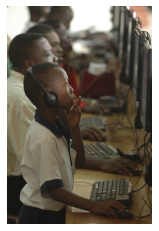

In [36]:
# load and display image with annotations

I = io.imread('http://images.cocodataset.org/val2014/COCO_val2014_000000'+ str(img_id) + '.jpg')
plt.imshow(I); plt.axis('off')
ax = plt.gca()
annIds = coco.getAnnIds(imgIds=img_id, iscrowd=None)
anns = coco.loadAnns(annIds)
coco.showAnns(anns)

loading annotations into memory...
Done (t=3.98s)
creating index...
index created!


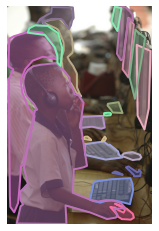

In [37]:
# load and display image with instance annotation
annFile = 'annotations/instances_val2014.json'
coco_caps=COCO(annFile)
annIds = coco_caps.getAnnIds(imgIds=img_id);
anns = coco_caps.loadAnns(annIds)

plt.imshow(I); plt.axis('off')
annIds = coco_caps.getAnnIds(imgIds=img_id, iscrowd=None)
anns = coco_caps.loadAnns(annIds)
coco_caps.showAnns(anns)

In [38]:
print("Predicted Annotation: {}".format("".join(list(true.values())[0])))

print("\nScores:\n{}".format(scores))

Predicted Annotation: a young boy wearing headphones using a laptop computer

Scores:
{'BLEU': [0.49869585755692136, 0.3462769864472256, 0.2800613307857243, 0.2201137161797883], 'METEOR': 0.28042874737681817, 'ROUGE': 0.5281385281385281, 'CIDEr': 0.0}
